**NAPOMENA**: Lab koji se odnosi na primenu i evaluaciju ML modela nad preciscenim dataset-om.

***Neki zaključci možda nisu 100% ispravni ako sam nešto zaboravila da ispravim, konačni rezultati nalaze se u samom radu i oni su najrelevantniji.***

# Instalacije

In [2]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.6 MB/s eta 0:00:00


In [3]:
!pip install imblearn

In [4]:
!pip install scipy

In [5]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [7]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

In [8]:
# metrike
from sklearn.metrics import (make_scorer, accuracy_score, precision_score,
    recall_score, f1_score,
    roc_curve, roc_auc_score,
    confusion_matrix)

In [9]:
# cross validacija
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_validate

In [10]:
# modeli
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [11]:
# importi za NN (neural networks)
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [12]:
# importi za NN (neural networks)
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# Funkcije

In [13]:
# funkcija kreirana za prikaz raspodele izmedju 0 i 1 vrednosti target varijable
def plot_data(target_data, title):
    plt.figure(figsize=(8,6))
    sns.countplot(x=target_data, palette='Set3')
    plt.title(title)
    plt.xlabel('Labels')
    plt.ylabel('Number of occurrences')

In [14]:
def print_metrics(accuracy, precision, recall, f1, cm):
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Confusion matrix: {cm}')

In [15]:
def calculate_print_metrics(real_value, predicted_value):
    accuracy = accuracy_score(real_value, predicted_value)
    precision = precision_score(real_value, predicted_value)
    recall = recall_score(real_value, predicted_value)
    f1 = f1_score(real_value,predicted_value)
    cm = confusion_matrix(real_value, predicted_value)

    print_metrics(accuracy, precision, recall, f1, cm)

In [16]:
def calculate_print_CV_metrics(cv_results):
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"Precision: {cv_results['test_precision'].mean()}")
    print(f"Recall: {cv_results['test_recall'].mean()}")
    print(f"F1 Score: {cv_results['test_f1'].mean()}")

# Ucitavanje preciscenog dataset-a

Ocisceni dataset je na drive-u pa ne mora da se upload-ovati, vec moze ovako direktno da se preuzme (preduslov je da pristup folderu imaju oni sa linkom).

In [17]:
download_link = 'https://drive.google.com/uc?id=1n_T6E9Z0lF5Dz5995MGXsUJqevq1AwU-'
dt = pd.read_csv(download_link)
dt.head()

# brisanje kolone sa rednim brojem opservacije koja jako utice na rezultat
dt = dt.drop(columns=['Unnamed: 0'])

# Podela dataset-a na X i na y set features-a
 * X (independent var) i na y (target - dependent var)
 * u nasem slucaju zavisna promenljiva je *Attack_type* koji je enkodovan u *encoded_attack*
 * *encoded_attack* ima vrednost 1 ako se napad desio, i vrednost 0 ukoliko se napad nije desio






In [18]:
predictor_features = [col for col in dt.columns if col != 'encoded_attack']
X = dt[predictor_features]
y = dt['encoded_attack']

In [19]:
print(len(X))
print(len(y))

123117
123117


# Promenljive

In [20]:
# za cross-validation strategy koriscen je StratifiedKFold
# deli se na 5 foldova jer je veliki dataset (inace bismo delili npr na 10) i pre podele se promeša dataset
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
# metrika koriscena prilikom podesavanja parametra
scoring_RS = {
    'f1': make_scorer(f1_score)
}
# broj iteracija za podesavanje parametara
n_iter = 10

In [22]:
# metrike za validaciju modela
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# TRAIN/TEST split


80% podataka biće korišćeno za trening set dok će 20% podataka biti korisceno kao test set.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Proveriti dimenziju podataka
print("Oblik X_train:", X_train.shape)
print("Oblik X_test:", X_test.shape)
print("Oblik y_train:", y_train.shape)
print("Oblik y_test:", y_test.shape)

Oblik X_train: (98493, 51)
Oblik X_test: (24624, 51)
Oblik y_train: (98493,)
Oblik y_test: (24624,)


**Zaključak**: train podatke ćemo koristiti za cross validaciju dok cemo test set ostaviti za konacnu validaciju modela nakon odabira najboljih parametara.

# Provera BALANSIRANOSTI

--> Numericki prikaz balansiranosti

In [103]:
# provera balansiranosti podataka
freq = dt['encoded_attack'].value_counts()
print(freq)

encoded_attack
1    110610
0     12507
Name: count, dtype: int64


In [104]:
# provera frekvencije
print(dt['encoded_attack'].value_counts(normalize=True))
# 0 je normalan saobracaj (oko 10%) a 1 je napad (oko 90%)

encoded_attack
1    0.898414
0    0.101586
Name: proportion, dtype: float64


--> Graficki prikaz balansiranosti

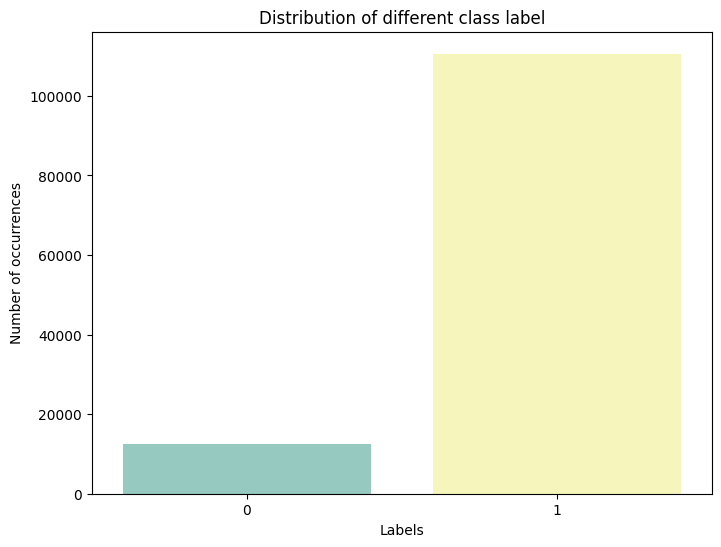

In [105]:
# pozivam fju koja je napisana ranije
plot_data(y, 'Distribution of different class label')

Na prikazanom grafiku vidi se da su podaci skroz nebalansirani, tj. da oko 10% opservacija ima za target varijablu vrednost 0, a cak 90% vrednost 1 ('desio se napad').

# BALANSIRANJE PODATKA - SMOTE

 Balansiraju se **samo trening podaci** pa cemo nadalje **umesto X_train, y_train** koristiti **X_resampled, y_resampled**. Za **test** podatke koristice se **X_test** i **y_test**.

Odabran je **oversampling** i to pomoću **SMOTE** metoda (preduslov je da su svi podaci numericki).

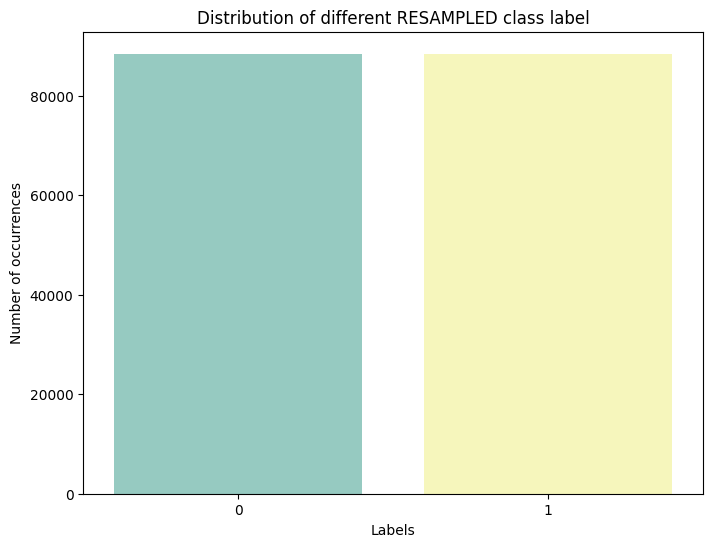

In [24]:
method = SMOTE()
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

# prikazivanje izbalansiranog seta
plot_data(y_resampled, 'Distribution of different RESAMPLED class label')

# OBJASNJENJE METRIKA

Podsetimo se da su napadi enkodovani kao 1, dok su normalne aktivnosti enkodovane kao 0.

***Zaključak o metrikama:***

- visoka preciznost je nizak FPR - FPR znači da su neke aktivnosti koje NISU napadi oznaceni kao napadi, i ok treba da se tezi visokoj preciznosti
- ali nama znacajniji je recall - ako je on visok to je nizak FNR - FNR znači da su neke aktivnosti koje SU napadi oznacene da nisu i tu je problem jer narusavamo bezbednost!

**NAMA JE NAJBITNIJI RECALL DA BUDE ZADOVOLJEN PA POTOM I PRECISION**

Kao dobar pokazatelj kako model klasifikuje, pogledacemo i confusion matrix.

# Baseline model - linearna regresija

**NAPOMENA: Koristiti na dalje (balansirani trening set) X_resampled, y_resampled, a ne X_train, y_train**

Koristicemo je kao referentnu tačku za sve ostale ML algoritme! Mogle smo odabrati i ZeroR, ali je izbor pao na linearnu regresiju (LR) jer ipak na njene rezultate utiču obelezja (features). LR se koristi inace za regresiju, ali je prilagodjena klasifikaciji jer smo pribegle podesavanju *threshold*-a.

LR je koriscena kao baseline model pa necemo raditi hyperparameter tuning za nju.

**1) Cross validacija nad trening setom za LR**

In [107]:
# kreiran je pipeline mada nije ni potrebno tako jer smo na primer balansiranje uradili unapred pa ne moramo i u pipeline-u
pipeline = Pipeline([
    ('logreg', LogisticRegression(random_state=42))
])

In [108]:
# Perform cross-validation and get prediction probabilities
y_pred_proba = cross_val_predict(pipeline, X_resampled, y_resampled, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]

Korišćen je default threshold (=0.5) i u sledećim ćelijama dobićemo određenu vrednost za sledeće metrike: 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', a može i 'roc curve'. Te metrike su dobijene nad trening skupom, te onda kad odlučimo da li ostavljamo ili menjamo ovaj default threshold onda ćemo i testirati baseline model samo nad test setom.

In [109]:
# Pretvaranje verovatnoća u klasifikacije pomoću praga 0.5 da bih mogla da dobijem metrike
y_pred_cv = (y_pred_proba >= 0.5).astype(int)

In [110]:
calculate_print_metrics(y_resampled, y_pred_cv)

Accuracy: 0.9191
Precision: 0.9739
Recall: 0.8613
F1 Score: 0.9141
Confusion matrix: [[86445  2042]
 [12273 76214]]




---


**Rezultati treniranja LR nad trening setom sa default threshold od 0.5:**

    Accuracy: 0.9191
    Precision: 0.9739
    Recall: 0.8613
    F1 Score: 0.9141
    Confusion matrix: [[86445  2042]
      [12273 76214]]

Recall koji je nama bitniji ima malo manju vrednost, ali je **F1 score** koji predstavlja balans izmedju recall i precision oko **0.9141**. FN ima oko 12273 sto moze biti problem jer tezimo sto manjem broju.

Da bismo ovo sredili, pogledacemo koji je optimalni threshold koji bi trebalo da bude postavljen.

---



**2) ROC Curve and ROC AUC score - za pregled i podesavanje threshold-a**

* **ROC CURVE**

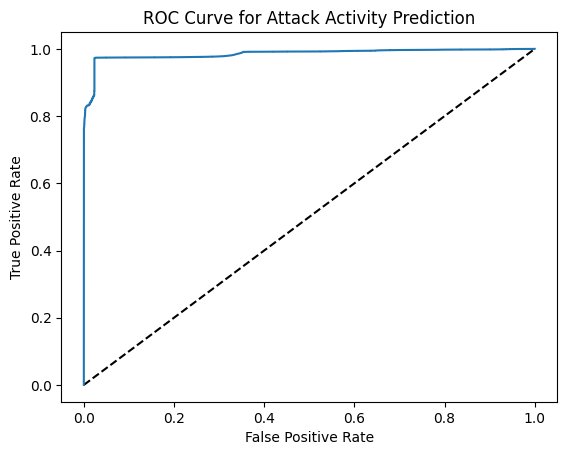

In [111]:
# ROC CURVE
fpr, tpr, thresholds = roc_curve(y_resampled, y_pred_proba)

plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Attack Activity Prediction')
plt.show()

Gore smo dobili ROC curve. Crna Isprekidana Linija predstavlja liniju slucajnog pogodka (Referentna Linija). Ova linija služi kao referentna tacka za poredjenje sa ROC krivom modela. ***Ako je ROC kriva iznad ove linije, izabrani model je bolji od slučajnog pogodka.*** Ako je ispod, model je gori od slučajnog pogodka. Plava linija obično predstavlja ROC krivu samog modela.

* **ROC AUC**
    - za početak ostavljam threshold LR na 0.5 i isto cu samo nad trening podacima

In [112]:
# use PROBABILITY not predicted values

# AUC = 0.5: The model performs no better than random guessing (chance level)
# AUC = 1.0: The model perfectly distinguishes between positive and negative instances.
# AUC < 0.5: The model performs worse than random guessing (this usually indicates an issue with the model or data).
print(roc_auc_score(y_resampled, y_pred_proba))

0.9853816723417352


Kada pokrenemo kod gore vidimo da je AUC score (dobro klasifikuje pozitivne slucajeve) 0.985 što je vrlo dobro, ali to možemo videti i na grafiku, ako želimo da nam je TPR bliži 1, a FPR bliži 0 na grafiku gledamo presek vrednosti najbližih tome i vidimo da je to negde oko 0.9. Takođe, vidimo da je plava linija iznad crne tako da nam model dobro klasifikuje i to bolje u odnosu na slucajnu klasifikaciju.

* Izračunavanje i primena najboljeg praga odlučivanja - **Youden-ov indeks**
  - odradićemo i podešavanje najboljeg threshold-a da vidimo i onda rezultate

In [113]:
# Izračunavanje Youden-ovog indeksa
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]
print(f'Optimal Threshold: {optimal_threshold:.2f}')

Optimal Threshold: 0.50


Rezultat nad preciscenim datasetom je takav da je optimalni **threshold ostao isti**, tj. po default, sto iznosi 0.5. Tako da necu primenjivati optimalni prag jer nema smisla dirati i prikazivati isto.

**3) Evaluacija modela LR nad test setom**

Prvo treniramo model nad resamplovanim trening podacima (ne radimo ovog puta cross validaciju), a potom izvrsimo validaciju modela nad test setom (koji nije balansiran).

In [114]:
pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('logreg', LogisticRegression(random_state=42))])

In [115]:
y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_test_pred_cv = (y_test_pred_proba >= 0.5).astype(int)

# Procena performansi na test skupu
calculate_print_metrics(y_test, y_test_pred_cv)

Accuracy: 0.8689
Precision: 0.9979
Recall: 0.8559
F1 Score: 0.9215
Confusion matrix: [[ 2461    40]
 [ 3187 18936]]


# Zakljucak za baseline model (LR)

Podsetimo se vrednosti metrika za trening set su:

    Accuracy: 0.9204
    Precision: 0.9737
    Recall: 0.8641
    F1 Score: 0.9157
    Confusion matrix: [[86425  2062]
      [12021 76466]]


Vrednosti metrika za test set su:

    Accuracy: 0.8689
    Precision: 0.9979
    Recall: 0.8559
    F1 Score: 0.9215
    Confusion matrix: [[ 2461    40]
        [ 3187 18936]]

Vremena:
    
    RandomizedSearch X
    CV treniranje+predikcija (trening set) 47 sec
    Obicno treniranje (nad trening setom za test set) 9 sec
    Predikcija za test set 0 sec

Precision, recall, kao i F1-score su vrlo priblizni za trening i test set sto je dobar rezultat jer ne dolazi do overfitting-a. Treniraćemo ostale modele kako bismo uporedili rezultat sa ovim metrikama nad test setom.

# Parameter tuning - uzorkovanje
 * **X_train_sample** i **y_train_sample** bice korisceni samo za podesavanje parametara dok ce
 * za treniranje konacnog modela sa najboljim parametrima biti nad celim balansiranim trening setom **X_resampled** i **y_resampled** (upotrebom cross validacije).

**RandomizedSearchCV** for parameter tuning - bolji je i brzi od GridSearchCV

Jako je spor kad bismo podesavali parametre nad celim trening setom pa cemo onda trening set uzorkovati (stratifikovano), kako bi nam bilo lakse i brze da podesimo parametre.

In [25]:
# Stratifikovano uzorkovanje nad trening podacima (npr. 10% skupa trening seta uzeto kao uzorak)
X_train_sample, _, y_train_sample, _ = train_test_split(X_resampled, y_resampled, train_size=0.1, stratify=y_resampled, random_state=42)

**X_train_sample** i **y_train_sample** bice korisceni samo za podesavanje parametara dok ce za treniranje konacnog modela sa najboljim parametrima biti nad celim balansiranim trening setom **X_resampled** i **y_resampled** (upotrebom cross validacije).

# Normalizacija podataka

  * podesavanje parametara ce se nakon normalizacije izvrsiti nad **X_train_sample_scaled**
  * algoritmi ce se obucavati nad **X_resampled_scaled**
  * testirati nad **X_test_scaled**
  * **y** vrednosti ostaju iste **y_resampled** i **y_test**

Normalizovani su podaci upotrebom **StandardScaler**-a. Normalizuju se podaci pre treniranja modela kako ne bi doslo do overfitting-a i kako bi model bolje klasifikovao vrednosti target varijable.

Skaliraju se trening i testing podaci (i uzorak) i to X deo, a ne skalira se y deo.

In [26]:
# skaliramo ceo trening i test set
scalerWholeSet = StandardScaler()
scalerWholeSet.fit(X_resampled)
X_resampled_scaled = scalerWholeSet.transform(X_resampled)
X_resampled_scaled=pd.DataFrame(X_resampled_scaled, columns=X.columns)
X_test_scaled = scalerWholeSet.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled, columns=X.columns)

# skaliramo uzorkovani set
scalerPartOfSet = StandardScaler()
scalerPartOfSet.fit(X_train_sample)
X_train_sample_scaled = scalerWholeSet.transform(X_train_sample)
X_train_sample_scaled=pd.DataFrame(X_train_sample_scaled, columns=X.columns)

# Napomena

Neke zaključke i vrednosti sam iskoristila jer sam posle različitih varijanti i testiranja zaključila da daju dobre i brže rezultate.

# KNN

**1) Podesavanje hiperparametara nad uzorkom**

In [118]:
# Dictionary of possible hyperparameter and its value
# postoje i hyperparams kao sto su metric i p, ali njih necu birati vec cu ostaviti default zbog predugog trajanja param param tuninga
param_dist = {"n_neighbors": [5,10,15,20],
              "weights" : ['uniform', 'distance']}

knn = KNeighborsClassifier()

random_search =\
    RandomizedSearchCV(
        estimator=knn,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=5,
        scoring=scoring_RS, # define metrics
        refit='f1',
        n_jobs=-1,
        random_state=42)

random_search.fit(X_train_sample_scaled, y_train_sample)


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'n_neighbors': [5, 10, 15, 20],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, refit='f1',
                   scoring={'f1': make_scorer(f1_score)})

In [119]:
# Access best parameters for f1 metric and best_score_ for that metric
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {random_search.best_score_}")

Best parameters: {'weights': 'distance', 'n_neighbors': 5}
Best score: 0.9929283347223505


U prethodnom delu videla sam koji parametri su mi najbolji za KNN za uzorak podataka. Sad cu da uzmem najbolje parametre, podesim ponovo KNN algoritam po tome, naucim ga nad CELIM (balansiran, normalizovan) trening setom i proverim sve metrike nad tim celim trening setom. Potrebno je raditi cross validaciju!

**2) Treniranje i evaluacija modela sa najboljim parametrima nad trening setom**

In [120]:
# Kreiranje novog modela sa najboljim hiperparametrima
best_knn = KNeighborsClassifier(**best_params)
# vrsimo cross validaciju
cv_results = cross_validate(best_knn, X_resampled_scaled, y_resampled, cv=skf, scoring=scoring)

In [121]:
calculate_print_CV_metrics(cv_results)

Accuracy: 0.9949088595731208
Precision: 0.9920673792733865
Recall: 0.9977962839042032
F1 Score: 0.9949235497098033


In [122]:
# Oko 4 min je trajalo pokretanje ovo radimo za matricu konfuzije pa necu ubacivati u vreme!!!
# Prikazivanje confusion matrix
predicted = cross_val_predict(best_knn, X_resampled_scaled, y_resampled, cv=skf)

In [123]:
cm = confusion_matrix(y_resampled, predicted)
print(cm)

[[87781   706]
 [  195 88292]]


Primena cross validacije nad KNN modelom sa najboljim parametrima dala je još bolji score, sa 0.9929 skočilo je na 0.99492 (gledam f1-score metriku).

**3) Treniranje i evaluacija modela sa najboljim parametrima nad test setom**

Nakon onoga iznad, moramo da vidimo kakve su predikcije i kakve su metrike za test podatke (skalirani, ali nisu balansirani - X_test_scaled). Y za test podatke nije ni skalirano ni balansirano (y_test). Ovde ne treba cross validacija da se radi vec obicno fit nad trening podacima and predict!! nad test podacima jer je u pitanju validacija nad test podacima.

In [124]:
# Nova instanca za treniranje pa validacijom nad TEST setom
best_knn_test = KNeighborsClassifier(**best_params)

In [125]:
# Fit nad trening podacima pa predict y za X_test_scale
best_knn_test.fit(X_resampled_scaled, y_resampled)

KNeighborsClassifier(weights='distance')

In [126]:
y_test_pred = best_knn_test.predict(X_test_scaled)

In [127]:
# prikaz metrika
calculate_print_metrics(y_test, y_test_pred)

Accuracy: 0.9972
Precision: 0.9988
Recall: 0.9980
F1 Score: 0.9984
Confusion matrix: [[ 2475    26]
 [   44 22079]]


# Zakljucak za KNN model

  --> sumirano: ***KNN je bolji u klasifikovanju od baseline modela (LR)***

Rezultati metrika za trening set:

    Accuracy: 0.9949088595731208
    Precision: 0.9920673792733865
    Recall: 0.9977962839042032
    F1 Score: 0.9949235497098033
    Confusion matrix: [[87781   706]
            [ 195 88292]]

Rezultati metrika za test set:

    Accuracy: 0.9972
    Precision: 0.9988
    Recall: 0.9980
    F1 Score: 0.9984
    Confusion matrix: [[ 2475    26]
            [  44 22079]]

Vremena:
    
    RandomizedSearch 22 sec
    CV treniranje+predikcija (trening set) 3 min 47 sec
    Obicno treniranje (nad trening setom za test set) 0 sec
    Predikcija za test set 40 sec

Vrednost metrika (recall, precision) nad test skupom su za nijansu vise (vrlo malo) od onih nad trening skupom, ali je sasvim prihvatljivo (ne bi bio zakljucak da je doslo do underfittinga ni overfittinga). U odnosu na baseline model vidimo da KNN sa ovim parametrima daje bolje rezultate. Takođe, FN rate je **dosta dosta** manji kod KNN nego kod baseline te ***KNN odnosi prednost nad baseline modelom (LR).***

# Random Forest (RF)

Koristimo balansirani i skalirani set podataka. Skaliranje nije uvek neophodno kod RF, ali ako zelimo da ovaj model poredimo sa ostalim koji zahtevaju skaliranje (LR, KNN) i ako hocemo da izracunamo feature importance, onda bi bilo dobro skalirati set.

**Skaliranje**

  * koristićemo onda X_resampled_scaled, X_train_sample_scaled, X_test_scaled - podsećanje, y se ne skalira, test set se ne balansira i koristicemo uzorak zbog RandomizedSearchCV

**1) Podesavanje hiperparametara nad uzorkom**


In [128]:
# koristile smo tipicne vrednosti
params_dist_rf = {'n_estimators': [100, 300, 500],
             'max_depth': [4, 6, 8],
             'min_samples_leaf': [1, 2, 4],
             'max_features': ['log2', 'sqrt']}

rfc = RandomForestClassifier(random_state=42)

random_searchRF =\
    RandomizedSearchCV(
        estimator=rfc,
        param_distributions=params_dist_rf,
        n_iter=n_iter,
        cv=5,
        scoring=scoring_RS,
        refit='f1',
        n_jobs=-1,
        random_state=42)

random_searchRF.fit(X_train_sample_scaled, y_train_sample)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 8],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [100, 300, 500]},
                   random_state=42, refit='f1',
                   scoring={'f1': make_scorer(f1_score)})

  * see the best score and the best values for params

In [129]:
best_params = random_searchRF.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {random_searchRF.best_score_}")

Best parameters: {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8}
Best score: 0.9957547305932355


  * mozemo videti i **feature importance** - i onda koristiti samo obelezja koja imaju vrednost importance iznad nekog praga - treba izbaciti ciljnu varijablu

In [130]:
best_rf = random_searchRF.best_estimator_
feature_importances = best_rf.feature_importances_

#  Display the feature importance
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)
# npr najvise uticaja ima flow_iat.min i to 0.105 dok neki imaju cak i 0.000

                     Feature  Importance
23              flow_iat.min    0.162881
25              flow_iat.tot    0.102186
34                active.tot    0.095984
24              flow_iat.max    0.093054
35                active.avg    0.089211
0              flow_duration    0.078588
20               fwd_iat.min    0.072610
16      bwd_pkts_payload.tot    0.063089
27          fwd_subflow_pkts    0.033780
28          bwd_subflow_pkts    0.030285
22               bwd_iat.max    0.027744
3        fwd_header_size_tot    0.020560
1          flow_pkts_per_sec    0.015326
9         bwd_PSH_flag_count    0.012965
4        bwd_header_size_tot    0.012338
13      fwd_pkts_payload.min    0.012074
21               bwd_iat.min    0.011129
46                 service_2    0.009747
50       bwd_header_size_avg    0.009263
29         fwd_subflow_bytes    0.008641
17     flow_pkts_payload.min    0.005939
14      fwd_pkts_payload.tot    0.004935
10       flow_ACK_flag_count    0.004820
19     flow_pkts

In [131]:
# stavicu threshold = 0.001 (otprilike po rezultatu) pa uzeti sva obelezja koja imaju feture importance iznad toga, a ostala cu iskljuciti
threshold = 0.001
important_features = importance_df[importance_df['Importance'] >= threshold]['Feature'].tolist()
# Reduce the training dataset to only include important features - napravila sam novi DF necu stari menjati da nebih posle kvarila kod
X_train_reduced = X_resampled_scaled[important_features]

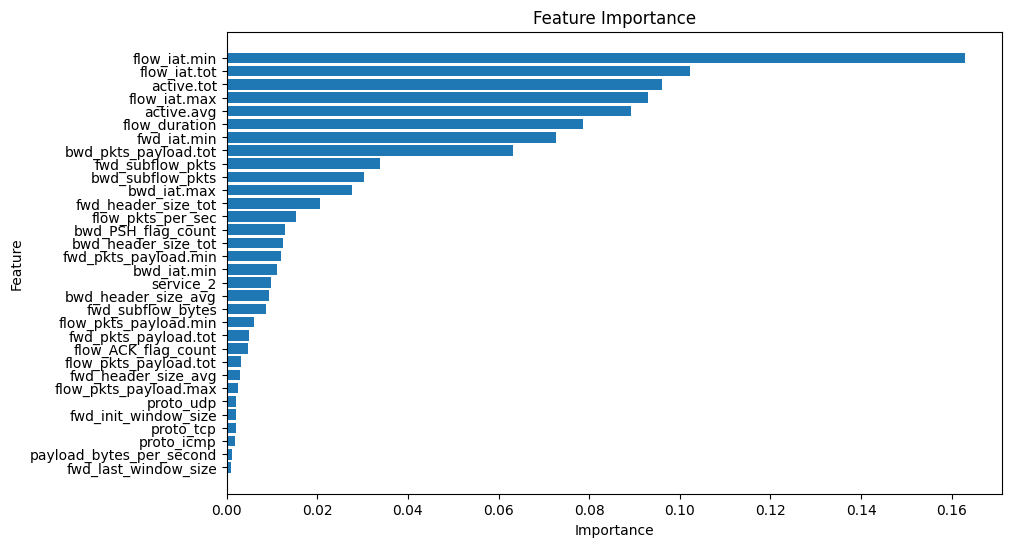

In [132]:
# Display feature importance on plot - stavicu samo one ciji je znacaj veci od 0,0001
important_features_DF = importance_df[importance_df['Importance'] >= threshold]

plt.figure(figsize=(10, 6))
plt.barh(important_features_DF['Feature'], important_features_DF['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

**2) Treniranje RF algoritma** sa najboljim parametrima i necemo proslediti ceo balansirani, skalirani trening set vec cemo iz njega samo izvući obeležja koja su najznačajnija (**X_train_reduced** ranije kreiran) i **validacija nad trening setom**

In [133]:
# Kreiranje novog modela sa najboljim hiperparametrima
best_rf = RandomForestClassifier(**best_params, random_state=42)

cv_results = cross_validate(best_rf, X_train_reduced, y_resampled, cv=skf, scoring=scoring)

In [134]:
calculate_print_CV_metrics(cv_results)

Accuracy: 0.9971577753223668
Precision: 0.999115107166808
Recall: 0.9951970409746369
F1 Score: 0.9971521560893496


In [135]:
# Prikazivanje confusion matrix - necu staviti u rezultate vremena
predicted = cross_val_predict(best_rf, X_train_reduced, y_resampled, cv=skf)

In [136]:
cm = confusion_matrix(y_resampled, predicted)
print(cm)

[[88409    78]
 [  425 88062]]




---


Vrednosti metrika nad trening setom (balansiranim, skaliranim i redukovanim nad bitnim obelezjima) i sa najboljim parametrima je:

    Accuracy: 0.9971577753223668
    Precision: 0.999115107166808
    Recall: 0.9951970409746369
    F1 Score: 0.9971521560893496
    Confusion matrix: [[88409    78]
            [  425 88062]]

Moramo videti kakvi su rezultati nad test setom kako bismo videli da li ima ili nema overfittovanja jer su jako dobri rezultati. Takođe, sad je precision oko 1, dok je best score nakon odabira najboljih parametara (bez izbacivanja obelezja) bio 0.9957.

Treba gledati i confusion matrix zbog FN i FP rate, mada mi je nesto to veliko --> Sad cemo proveriti i nad test setom rezultate..


---



**3) Treniranje RF algoritma** sa najboljim parametrima (bez CV) i **validacija** nad redukovanim **test setom** (uzeta samo obelezja bitna po RF algoritmu)

In [137]:
# nova instanca za test set
best_rf_test = RandomForestClassifier(**best_params, random_state=42)
# Fit pa predict
best_rf_test.fit(X_train_reduced, y_resampled)
# predikcija y za X_test_scaled
X_test_scaled_reduced = X_test_scaled[important_features]

In [138]:
y_test_pred = best_rf_test.predict(X_test_scaled_reduced)

In [139]:
calculate_print_metrics(y_test, y_test_pred)

Accuracy: 0.9950
Precision: 0.9995
Recall: 0.9948
F1 Score: 0.9972
Confusion matrix: [[ 2491    10]
 [  114 22009]]


Sve metrike nad test podacima isto daju vrednost oko 1, a matrica za FN i FP ima vrednost 114 i 10. Test podaci nisu balansirani tako da je ovo dobar rezultat sto znaci da je algoritam okej klasifikovao instance. To znaci da model okej klasifikuje i pozitivne i negativne klase.

## Zakljucak za RF


Vidi se na rezultatima iznad. Kod RF imamo jos jedan korak, a to je odredjivanje bitnosti obelezja i njihovo uklanjanje.

# XGBoost

**1) Hyperparameter tuning** with RandomizedSearchCV

  * use **X_train_sample_scaled** and **y_train_sample**
  * XGBoost za treniranje koristi DMatrix, ali ovde nece biti potrebno jer XGBClassifier sam prevodi dataframe u matricu

In [27]:
gbm_param_grid = {'learning_rate': np.arange(0.05,1.05,.05),
                  'n_estimators': [100, 300, 500],
                  'subsample': np.arange(0.05,1.05,.05),
                  'max_depth': [4, 6, 8]}

# objective=classification is default for it
gbm = xgb.XGBClassifier()

random_searchGB =\
    RandomizedSearchCV(
        estimator=gbm,
        param_distributions=gbm_param_grid,
        n_iter=n_iter,
        cv=5,
        scoring=scoring_RS,
        refit='f1', # koristim f1 kod svih optimizacija jer je to balans izmedju precision i recall sto me i zanima
        n_jobs=-1,
        random_state=42)

random_searchGB.fit(X_train_sample_scaled, y_train_sample)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   random_state=42, refit='f1',
                   scoring={'f1': make_scorer(f1_score)})

In [28]:
best_params = random_searchGB.best_params_
print(f"Best parameters: {best_params}")

print(f"Best score: {random_searchGB.best_score_}")

Best parameters: {'subsample': 0.7500000000000001, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.4}
Best score: 0.9967754578806133


**2) Training** and **evaluating** the ML model on **entire training set** with the best params - CV se radi

In [29]:
# Novi model sa najboljim parametrima nad celim trening setom
best_model = xgb.XGBClassifier(objective='binary:logistic',
                                params=best_params,
                                seed=123)

cv_results = cross_validate(best_model, X_resampled_scaled, y_resampled, cv=skf, scoring=scoring)

In [30]:
# Print scoring metrics - ovo su rezultati metrike kad se pokrene KNN sa najboljim parametrima nad CELIM TRENING SETOM
calculate_print_CV_metrics(cv_results)

Accuracy: 0.9980392610257794
Precision: 0.9994448282014193
Recall: 0.9966322767298571
F1 Score: 0.998036453937081


Get confusion matrix for entire training set (need to train an predict again on training set)

In [31]:
# Prikazivanje confusion matrix - necu ubacivati u vreme
predicted = cross_val_predict(best_model, X_resampled_scaled, y_resampled, cv=skf)

In [32]:
cm = confusion_matrix(y_resampled, predicted)
print(cm)

# OVO JE PROVERA KOLIKO IMAMO OBSERVACIJA
# u trening setu imamo 176974 opservacije jer smo uradili SMOTE
print(len(y_resampled))
print(len(predicted))

[[88438    49]
 [  298 88189]]
176974
176974




---


Komentari za validacijom nad trening setom.

I za XGBoost vrednosti za trening set su:
    
    Accuracy: 0.9980392610257794
    Precision: 0.9994448282014193
    Recall: 0.9966322767298571
    F1 Score: 0.998036453937081

Matrica konfuzije daje:

      [[88438    49]
      [  298 88189]]


Vreme izvršavanja:


*   RandomizedSearchCV - 59 sec
*   CV (treniranje i predikcija) - 19 sec

---




**3) Training on entire training set and evaluating on the test set the ML model with the best params**

In [33]:
# kreiracu novi klasifikator sa najboljim parametrima ali cu ga trenirati nad trening setom, a validirati nad test setom
xg_cl_test = xgb.XGBClassifier(objective='binary:logistic',
                                params=best_params,
                                seed=123)
xg_cl_test.fit(X_resampled_scaled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 300,
                      'subsample': 0.7500000000000001}, ...)

In [34]:
preds_test = xg_cl_test.predict(X_test_scaled)

In [35]:
calculate_print_metrics(y_test, preds_test)

Accuracy: 0.9965
Precision: 0.9996
Recall: 0.9966
F1 Score: 0.9981
Confusion matrix: [[ 2492     9]
 [   76 22047]]




---


Nad test setom su sledeće metrike:

    Accuracy: 0.9965
    Precision: 0.9996
    Recall: 0.9966
    F1 Score: 0.9981
    Confusion matrix: [[ 2492     9]
          [   76 22047]]


Vreme izvršavanja:

*   Treniranje nad trening radi predikcije nad test - 4 sec
*   Predikcija nad test setom - 0 sec




---



# Neuronske mreze

Drugačiji pristup i način od prethodnog, obratiti pažnju na različitosti.

Odabran je Multilayer Perception i odgledan je kurs *Introduction to Deep Learning in Python* https://app.datacamp.com/learn/courses/introduction-to-deep-learning-in-python pomoću kog sam napisala kod (neke beleške su na https://docs.google.com/document/d/1K5YR9JxtzBTK_GsHEq3ezO5HNFKnnntWVWm8cjZbUD8/edit kao i u *notes* na kursu)

**1) Prvi korak jeste kreiranje modela i arhitekture neuronske mreze**

Preporuka je da se krene od najjednostavnije mreže i da se postepeno usložnjava i prate metrike, međutim, nemamo mnogo vremena pa je izabrana arhitektura po preporuci

In [36]:
# definisemo nacin treniranja modela - a to je da su slojevi mreze poredjani jedan do drugog
# neurons are organized in layers that are stacked sequentially one after the other
model = Sequential()

# MLP NN jeste Sequential model ciji su nodes (cvorovi) Dense

Kreiranje ulaznog (input) sloja

In [37]:
# input_shape parametar u prvom sloju definiše broj obeležja (feature-a) u tvojem datasetu koji se koriste kao ulazi u mrežu
# 58 neurona u ulaznom sloju odgovara broju obeležja u datasetu - svaki neuron u ulaznom sloju predstavlja jedno obeležje
input_dim = X_resampled_scaled.shape[1]

print(input_dim)

51


In [38]:
# Dense is the type of nodes
# prosledjujemo broj cvorova u ulaznom sloju - 128 po preporuci (Veći broj neurona povećava kapacitet modela, omogućavajući mu da uči detaljnije karakteristike iz podataka)
# prosledjuemo type of activation function - omogucava modelu da prihvata i nelinearnost izmedju obelezja
# ako je izlazna vrednost negativan broj ReLU fja ga postavlja na 0
model.add(Dense(128, input_shape=(input_dim,), activation='relu'))

Kreiranje jos 2 skrivena sloja

In [39]:
# Drugi i treći slojevi služe za postepeno smanjenje dimenzionalnosti, što pomaže modelu da bolje generalizuje.
# Smanjenje broja neurona pomaže mreži da se fokusira na važnije karakteristike koje su se pokazale značajnim u prethodnom sloju
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

Kreiranje izlaznog sloja - u pitanju je binarna klasifikacija

In [40]:
# tako da za svaku mogucu vrednost target varijable imamo po 1 čvor
# model.add(Dense(2, activation='softmax'))

# ali brze i jednostavnije je primeniti ovo za binarnu klas, a da se iznad to upotrebi za viseklasnu klasifikaciju
model.add(Dense(1, activation='sigmoid'))

**2) Kompajliranje modela**

Modelu treba naglasiti koju ***loss function*** da koristi (Njena osnovna svrha je da meri koliko se predikcije modela razlikuju od stvarnih vrednosti i da pruži povratnu informaciju koja se koristi za prilagođavanje težina modela tokom treniranja.)

Takođe, treba definisati i ***optimizer*** (npr ima ***Adam*** i SGD) --> Adam je preporučljiviji jer je često efikasan, adaptivan, ne treba mnogo ručno da se podešava.

Metriku koristim kao i do sad pa su potrebna podešavanja.

In [41]:
# binary_crossentropy se koristi uz sigmoid, dok se categorical_crossentropy koristi vise za softmax te obratiti paznju
# JAKO JE BITNA OVA NAPOMENA DA BI MODEL RADIO!!!
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])

**3) Podešavanje parametara** - learning rate (LR)

Postoji *learning rate* (default 0.01) koji cu ovde da podesim koriscenjem automatskih alata, wights je parametar koji se automatski sam podešava prilikom kreiranja i treniranja NN modela.

Nema ovde RandomizedSearchCV

In [42]:
# pokrece se model par puta sa razlicitim LR i gleda se napredak tj smanjenje greske
# ako dodje do stagnacije (posmatrajući metrike) nakon 3 epohe onda se prekida i uzima najbolje
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

**4) EarlyStopping**

U NN modelima se ne koristi k-fold CV jer bi puno kostala te se koristi ovo (detalje iscitati negde ako zaboravis sta je).

In [43]:
# ako dodje do stagnacije (posmatrajući metrike) nakon 3 epohe onda se prekida i uzima najbolje
early_stopping_monitor = EarlyStopping(patience=3)

**5) Treniranje modela**

Koristi i skalirane (obavezno) i balansirane podatke, ali neću ovog puta koristiti uzorak već ceo trening dataset, a on prilikom treniranja uzima deo za validaciju (validation split) dok ne dodje do najboljeg rezultata (to je kombinacija sa EarlyStopping kako bi se postigao CV kao kod drugih modela)

In [44]:
# maksimalni broj epoha je 50, ali earlystopping moze i ranije da zavrsi
# takodje imamo i podesavanje LR najboljeg ovde
history_of_fitting = model.fit(X_resampled_scaled, y_resampled, epochs=50, validation_split=0.2, callbacks=[early_stopping_monitor, reduce_lr])

Epoch 1/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0812 - precision: 0.9854 - recall: 0.9712 - val_loss: 0.0308 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0232 - precision: 0.9932 - recall: 0.9948 - val_loss: 0.0310 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0186 - precision: 0.9946 - recall: 0.9954 - val_loss: 0.0148 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 0.0173 - precision: 0.9946 - recall: 0.9954 - val_loss: 0.0239 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0166 - precision: 0.9950 - recall: 0.9959 - val_loss: 0.0197 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning

In [45]:
# Prikaz evaluacije na trening skupu
loss, precision, recall = model.evaluate(X_resampled_scaled, y_resampled)
print(f"Loss: {loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

5531/5531 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0168 - precision: 0.9970 - recall: 0.9965
Loss: 0.018468057736754417
Precision: 0.9908866286277771
Recall: 0.9965192675590515


**Matrica konfuzije:**

Ne postoji drugi način nego ovako....

In [47]:
y_train_pred_prob = model.predict(X_resampled_scaled)

5531/5531 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [48]:
y_train_pred = (y_train_pred_prob > 0.5).astype(int)

cm_train = confusion_matrix(y_resampled, y_train_pred)
print("Confusion Matrix (Train Set):")
print(cm_train)

Confusion Matrix (Train Set):
[[87676   811]
 [  308 88179]]


**ZAKLJUCAK ZA TRENIRANJE**

Stalo je na epohi 6 od maksimalno 50 i najbolji rezultat je:

    Loss: 0.018468057736754417
    Precision: 0.9908866286277771
    Recall: 0.9965192675590515

Dok je matirica konfuzije pokazala:

    [[87676   811]
    [308 88179]]


**6) Evaluacija modela nad test setom**

In [49]:
# Prikaz evaluacije na trening skupu - fit smo odradili pa necu opet
loss, precision, recall = model.evaluate(X_test_scaled, y_test)
print(f"Loss: {loss}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

770/770 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0212 - precision: 0.9982 - recall: 0.9952
Loss: 0.01903693377971649
Precision: 0.9985037446022034
Recall: 0.9954346418380737


In [50]:
y_test_pred_prob = model.predict(X_test_scaled)
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

cm_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Set):")
print(cm_test)

770/770 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Confusion Matrix (Test Set):
[[ 2468    33]
 [  101 22022]]


**ZAKLJUCAK ZA TESTIRANJE**

Rezultat je:

    Loss: 0.01903693377971649
    Precision: 0.9985037446022034
    Recall: 0.9954346418380737

Dok je matirica konfuzije pokazala:

    [[ 2468    33]
    [ 101 22022]]

## KONACAN ZAKLJUCAK

RandomForest and XGBoost su najbolji algoritmi sa istim rezultatima, ali bih prednost dala XGBoostu jer nismo smanjivali dodatno dataset (kod RF smo racunali feature importance pa izbacivali obelezja) i mnogo je brzi (sve uradi za par sekundi - jer efikasno koristi paralelizaciju i optimizaciju kod treniranja modela). A oba ova, kao i KNN su nadmašili linearnu regresiju (LR).


U suštini rezultati su dosta slični i za NN kao i za prethodne, za nijansu je NN slabiji, ali to možda zavisi i od arhitekture koju neću specijalno podešavati za sada.

Kroz diskusiju i o samim algoritmima kao i detaljniju analizu videćemo koji je bolji (biće u radu).